# Using a Multiple Linear Regression Classifier with the Auto Dataset

The aim of this program is to create a multiple linear regression classifier that is capable of predicting the miles per gallon performance of a vehicle, given a training dataset consisting of variables including horsepower, weight and number of cylinders. It will also demonstrate some techniques in data pre-processing and analysis.

We begin by reading the data into a Pandas data frame. When we don't use the test_train_split function, which performs the shuffle itself, it is vital to shuffle the data if we intend to later split it into minibatches. This ensures that any biases or patterns in the samples are removed. Following this we check the data types and for any missing values, assign y to the target variable which is 'miles per gallon', and visualise the distribution of this variable.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.utils import shuffle
import seaborn as sns

df = pd.read_csv('Auto.csv')
# shuffle data before use with sklearn
df = shuffle(df)
# check data types
df.info()
# check if there are any missing values in the data
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 253 to 346
Data columns (total 9 columns):
mpg             397 non-null float64
cylinders       397 non-null int64
displacement    397 non-null float64
horsepower      397 non-null object
weight          397 non-null int64
acceleration    397 non-null float64
year            397 non-null int64
origin          397 non-null int64
name            397 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 31.0+ KB
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


There are no missing values in the dataset. However, we notice that the 'horsepower' column is type object and not a numeric type. On further inspection we find several '?' in the column that must represent missing values. We could choose to impute these missing values, but we will just remove these rows as there are only a few of them. Then we can convert the column to a numeric type. 

Next we produce a correlation matrix between all the variables. From this we can gain an idea of which features are most likely to have greater predictive power in the model and we could choose to exclude any with a neglible correlation with the target. The correlation matrix aalso allows us to investigate multicollinearity within the dataset. It is evident that we have collinearity between several features (cylinders, displacement, horsepower, and weight). There are a number of ways we can proceed after identifying an issue with multicollinearity in the dataset. Our approach will be to employ regularisation.

We also generate a pairplot between the variables. This function produces a plot between each feature and a distribution plot of each feature. 

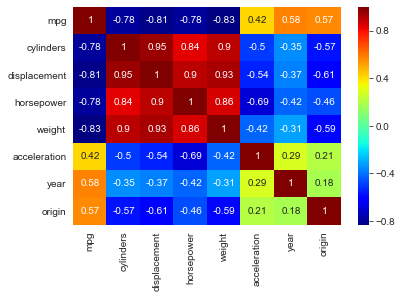

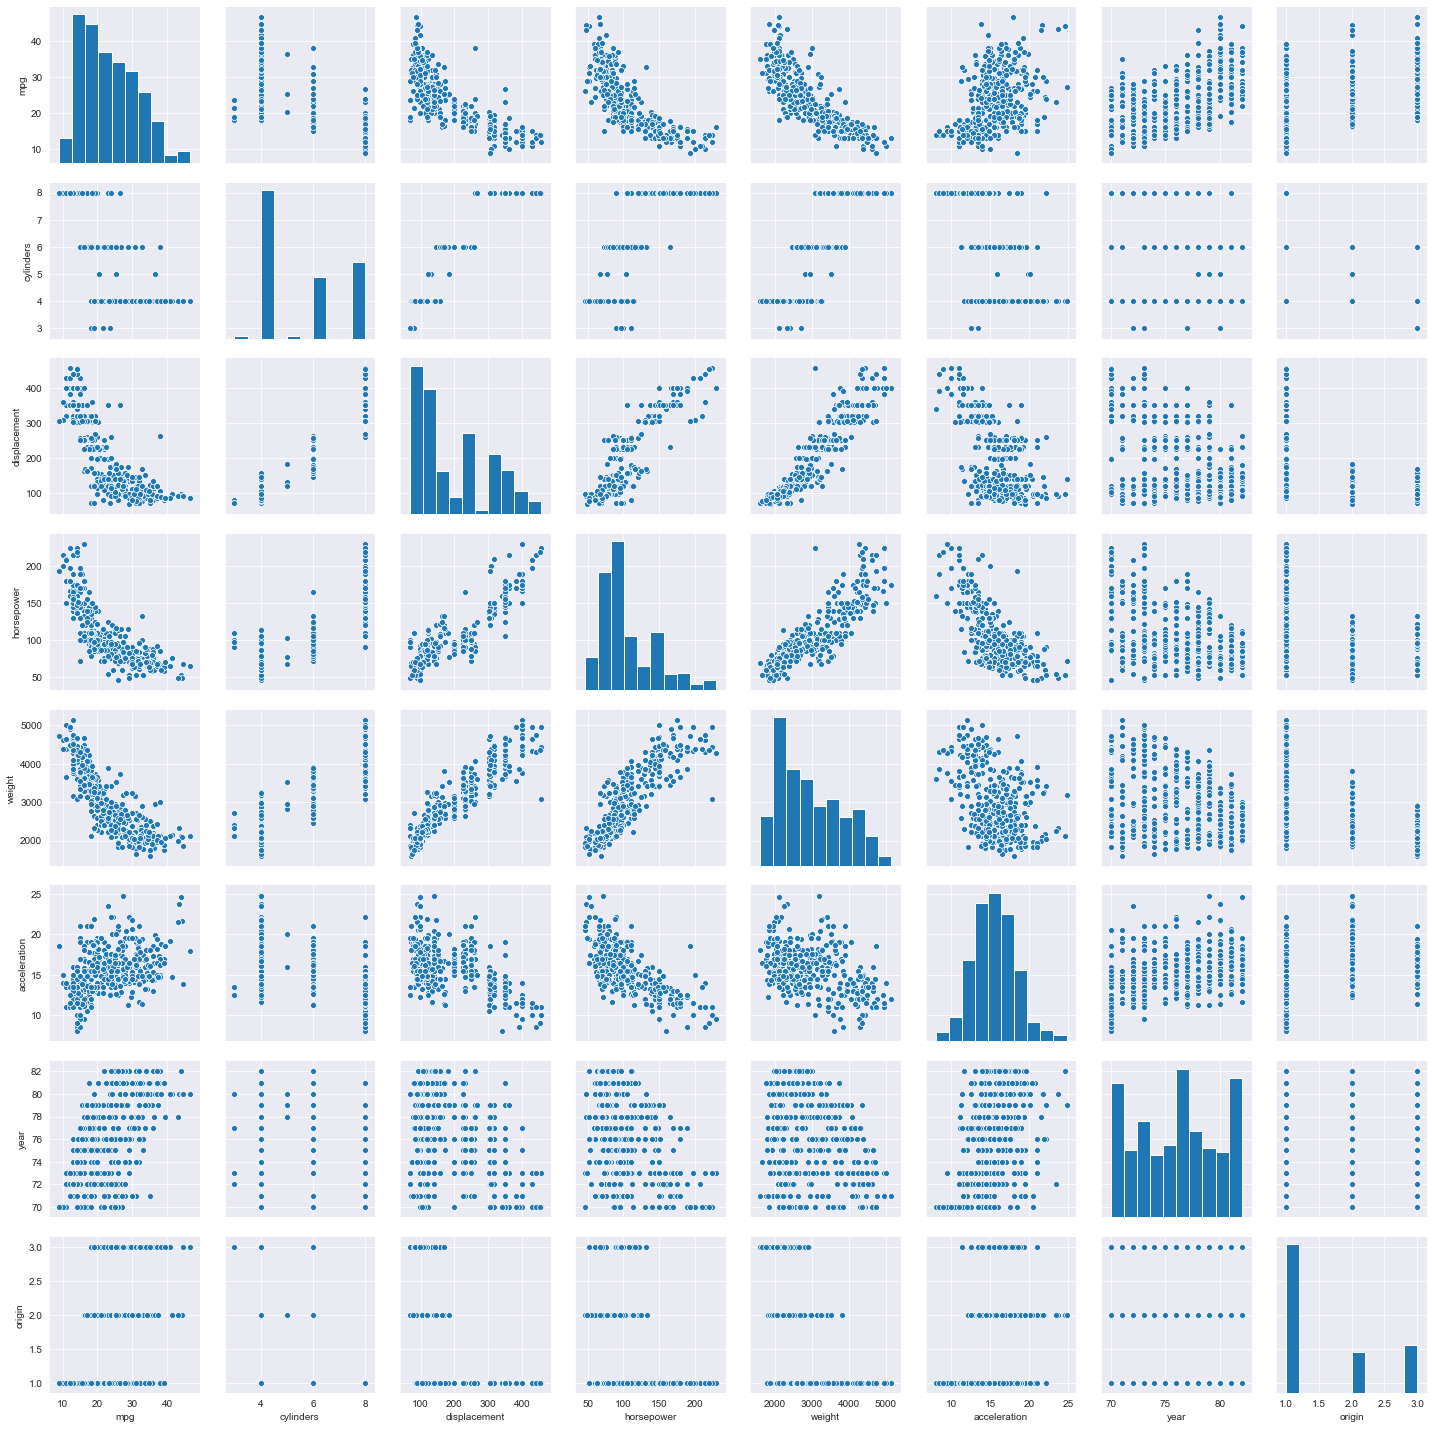

In [55]:
# get indexes of column where value is '?'
indexes = df[df['horsepower'] == '?'].index
# drop all rows given by 'indexes'
df.drop(indexes, inplace = True)

# change horsepower values from object to float
df['horsepower'] = pd.to_numeric(df['horsepower'])
# create a correlation matrix that measures the relationships between the variables
correlation_matrix = df.corr().round(2)
# visualise the matrix
fig = plt.figure()
ax = sns.heatmap(correlation_matrix, annot = True, cmap = 'jet')
# plot pairplot of all features
ax = sns.pairplot(df)
plt.show()

We can produce a larger plot of the target distribution.

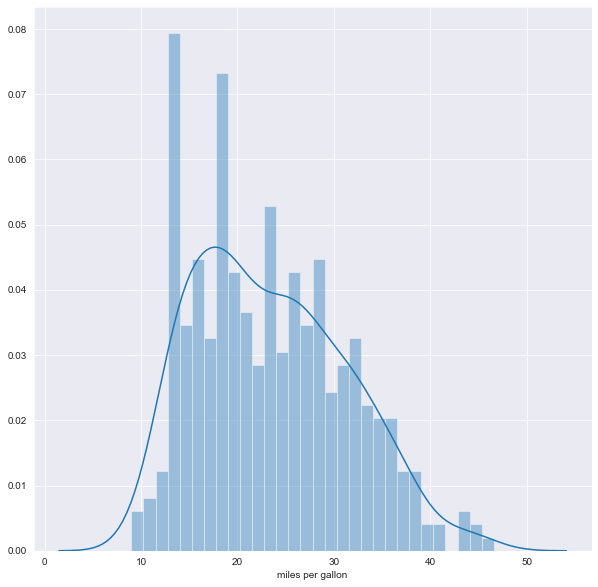

In [56]:
# assign the target variable and reshape for scikit learn
y = pd.Series(df['mpg'], name = 'miles per gallon')

# create a distribution plot of the data
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
ax = sns.distplot(y, bins = 30)
plt.show()

We can see that the variable has a right-skewed normal distribution.

In [57]:
# assign features to X, dropping the 'name' column
X = df.drop(['mpg', 'name'], axis = 1)
X.head(10)

,cylinders,displacement,horsepower,weight,acceleration,year,origin
253,6,200.0,95,3155,18.2,78,1
168,4,140.0,83,2639,17.0,75,1
53,4,71.0,65,1773,19.0,71,3
254,6,200.0,85,2965,15.8,78,1
258,6,231.0,105,3380,15.8,78,1
265,8,318.0,140,4080,13.7,78,1
240,4,97.0,78,2190,14.1,77,2
99,6,232.0,100,2945,16.0,73,1
48,6,250.0,88,3139,14.5,71,1
335,4,122.0,88,2500,15.1,80,2


The values of the features vary by orders of magnitude, so it is important that we perform scaling before using regularisation. We will use StandardScaler which calculates the z-score of each value:
$$Z = \frac{x - \mu}{\sigma}$$ where $x$ is the observed value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.

In [58]:
scaler = StandardScaler()
# apply scaling to features
X_scaled = scaler.fit_transform(X)

Elastic Net regularisation (E) employs a linear combination of lasso (L1) and ridge (L2) regularisation, i.e., $E = aL1 + bL2$, where $a$ and $b$ are constants. The L1 ratio corresponds to $a/(a+b)$: an L1 ratio of one is equal to lasso regression, a ratio of zero is equal to ridge regression, and anything in between is a combination of the two.

The regularised linear regression cost function utilises the regularisation parameter $\alpha$. Sklearn makes use of the same parameter, where $\alpha = a+b$ in elastic net regularisation.

We are going to generate an elastic net estimator and grids of the L1 ratio and $\alpha$ to perform a grid search over. Via this method we can identify the best type of regularisation and $\alpha$ for the model.

In [59]:
# create the L1 hyperparameter space
l1_space = np.linspace(0, 1, 30)
# create a range of alphas to test and identify the optimum value
alpha_space = np.logspace(-3, 2, 50)
param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}
# instantiate the ElasticNet regressor
elastic_net = ElasticNet()
# generate the GridSearch object
reg_cross_val = GridSearchCV(elastic_net, param_grid, cv = 5)
# fit to the data
reg_cross_val.fit(X_scaled, y)

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1777.2185005086947, tolerance: 1.9438878466453677
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1536.7118144605608, tolerance: 1.8375789904153355
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1652.9569988645221, tolerance: 1.8916191114649683
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1807.9036070304007, tolerance: 1.9438878466453677
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1567.0753250423018, tolerance: 1.8375789904153355
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1675.8626279617113, tolerance: 1.8916191114649683
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1933.519432299014, tolerance: 1.9438878466453677
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1684.010418951552, tolerance: 1.8375789904153355
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1772.319892021977, tolerance: 1.8916191114649683
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2310.857859147761, tolerance: 1.9438878466453677
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2028.8832505974542, tolerance: 1.8375789904153355
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2101.2785951850833, tolerance: 1.8916191114649683
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3343.4077472089, tolerance: 1.9438878466453677
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3037.9729734638377, tolerance: 1.8375789904153355
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3141.8389190749344, tolerance: 1.8916191114649683
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5733.299729126215, tolerance: 1.9438878466453677
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5383.0924229372995, tolerance: 1.8375789904153355
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5583.581310802128, tolerance: 1.8916191114649683
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8959.68176537599, tolerance: 1.9438878466453677
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8472.162027400289, tolerance: 1.8375789904153355
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8738.8327627407, tolerance: 1.8916191114649683
  positive)
C:\Users\marti\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2....
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [60]:
print(reg_cross_val.best_params_)

{'alpha': 0.08685113737513529, 'l1_ratio': 1.0}


The grid search selects lasso regularisation and a small $\alpha$ for optimal performance.

Linear regression uses the coefficient of determination, $R^2$ to measure model performance. It is defined as the proportion of variance in the dependent variable that is predictable from the independent variables. The coefficient of determination normally ranges from zero to one, with a value of one representing the model perfectly fitting the data.

In [61]:
print('Best cross-validated R^2 score: {:.2f}'.format(reg_cross_val.best_score_))

Best cross-validated R^2 score: 0.81


Technically, for a multiple linear regression model we should use the adjusted coefficient of determination $\hat{R^2}$, which is defined as $$\hat{R^2} = 1 - (1-R^2)\frac{(n-1)}{(n-p-1)}$$

In [62]:
def adj_r2(r_squared, X):
    n, p = X.shape
    return 1 - (1 - r_squared)*((n - 1)/(n - p - 1))

print('Adjusted R^2 score for multiple linear regression: {:.2f}'.format(adj_r2(reg_cross_val.best_score_, X_scaled)))

Adjusted R^2 score for multiple linear regression: 0.81
